# 深入研究量子线路

## 准备工作

1. 引入必要的数据处理模块numpy和pandas；
2. 设定matplotlib绘图的风格；
3. 引入QisKit库并打印版本信息。

In [1]:
# Import necessary data-processing modules
import numpy as np
import pandas as pd

# Control matplotlib style (white background)
%matplotlib inline
from matplotlib import style
style.use('seaborn-white')

# Import QisKit
import qiskit
import qiskit.tools.jupyter
%qiskit_version_table

## 准备线路

QisKit中定义了便捷的量子线路类`QuantumCircuit`，可以直接使用构造函数创建线路，所带两个参数分别为线路中使用到的量子比特数和经典比特数。如下所示，定义了一个包含4个量子比特和2个经典比特的线路，在经历一系列单比特门、两比特门和三比特门操作后，将后两个量子比特的值读取到两个经典比特中。

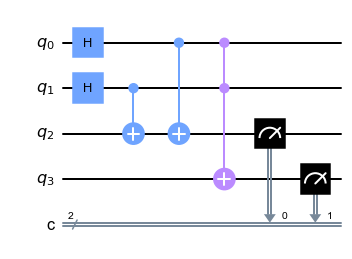

In [2]:
# prepare quantum circuit
circuit = qiskit.QuantumCircuit(4, 2)
circuit.h(0)
circuit.h(1)
#circuit.barrier()
circuit.cx(1, 2)
circuit.cx(0, 2)
circuit.ccx(0, 1, 3)
#circuit.barrier()
circuit.measure([2, 3], [0, 1])
circuit.draw()

## 分析线路

上述线路可以分为4个阶段：

1. 在 $Q_0$ 和 $Q_1$ 上应用哈达玛门，将它们转变为`|0>`、`|1>`之间等比例的随机状态；
2. 在 $Q_2$ 上连续添加两个CX门，控制比特分别为 $Q_0$ 和 $Q_1$ ，此时，$Q_2$ 就变成了 $Q_0$、$Q_1$ 的异或运算；
3. 在 $Q_3$ 上应用CCX门，控制比特分别为 $Q_0$ 和 $Q_1$，此时，$Q_3$ 就变成了 $Q_0$、$Q_1$ 的与运算；
4. 将 $Q_3$ 和 $Q_4$ 分别读取到经典比特的第0位和第1位。

做出 $Q_0$、$Q_1$ 4种状态对应的输出结果对应表如下：

| $Q_0$ | $Q_1$ | $Q_2$ | $Q_3$ | P |
| ---- | ---- | ---- | ---- | ---- |
| 0 | 0 | 0 | 0 | 25% |
| 0 | 1 | 1 | 0 | 25% |
| 1 | 0 | 1 | 0 | 25% |
| 1 | 1 | 0 | 1 | 25% |

可以看出读出结果为`|00>`概率为25%，`|01>`概率为50%，`|10>`概率为25%。

## 模拟

### 状态向量

QisKit提供量子线路的状态向量模拟，首先创建并初始化状态向量，然后应用定义好的量子线路，就可以得到最终的状态空间。

**注意**：状态向量不能模拟经典比特，因此，需要去除经典测量操作才可以使用状态向量进行模拟。

In [3]:
circuit_q = qiskit.QuantumCircuit(4)
circuit_q.h(0)
circuit_q.h(1)
circuit_q.cx(1, 2)
circuit_q.cx(0, 2)
circuit_q.ccx(0, 1, 3)

state = qiskit.quantum_info.Statevector.from_int(0, 2**4) # generate and initialize state vector
state = state.evolve(circuit_q) # apply circuit

print(state)

Statevector([0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0.5+0.j,
             0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j,
             0. +0.j, 0. +0.j],
            dims=(2, 2, 2, 2))


状态向量演化结果的主要可视化方法：

1. 状态概率函数；
2. 状态概率向量；
3. 量子球；
4. Hinton图；
5. 概率矩阵三维图。

In [4]:
state.draw('latex')

<IPython.core.display.Latex object>

In [5]:
qiskit.visualization.array_to_latex(state)

<IPython.core.display.Latex object>

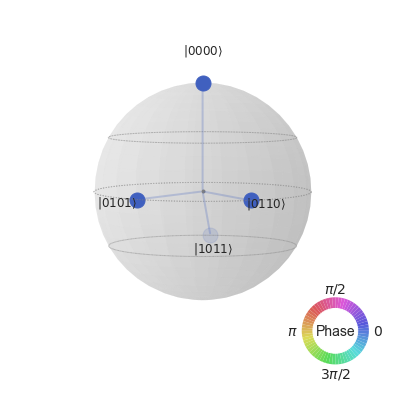

In [6]:
state.draw('qsphere')

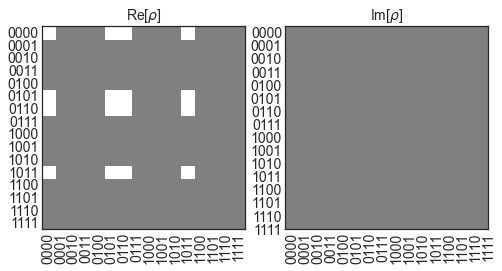

In [7]:
state.draw('hinton')

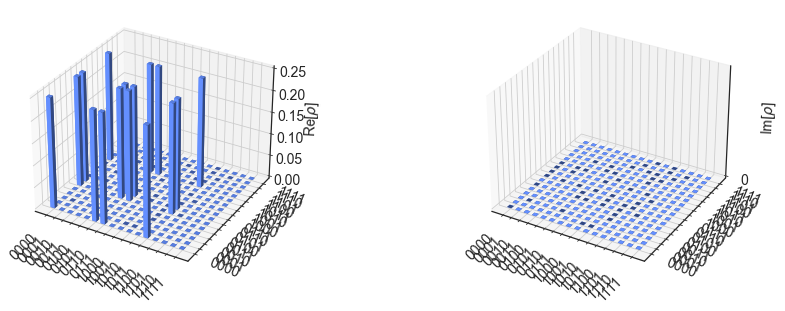

In [8]:
qiskit.visualization.plot_state_city(state)

### 算子

QisKit能够计算量子线路对应的转换矩阵算子，和状态向量模拟一样，矩阵算子不支持包含测量的线路。

In [9]:
U = qiskit.quantum_info.Operator(circuit_q)
print(U)

Operator([[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,
            0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
            0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j,
            0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
            0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,
           -0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
            0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
            0. +0.j,  0. +0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j,
            0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j,  0.5+0.j,
            0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j,
            0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
          [ 0.5+0.j, -0.5+0.j,

### QASM 模拟

将量子线路汇编成OpenQASM后，就可以使用QisKit的模拟器模拟量子线路在真实量子芯片上运算的结果。

步骤上主要分为3步：

1. 汇编；
2. 模拟运行；
3. 可视化结果。

Simulation result: {'00': 291, '10': 247, '01': 486}


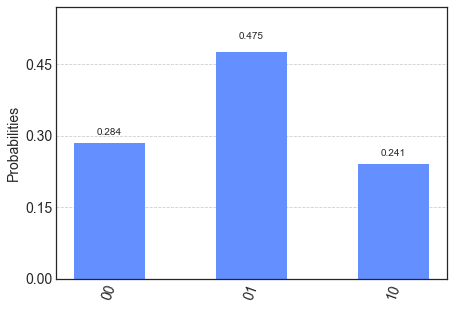

In [10]:
# prepare OpenQasm simulator backend
backend = qiskit.providers.aer.QasmSimulator()

# generate OpenQasm
qasm = qiskit.transpile(circuit, backend)

# run qasm in simulator
job = backend.run(qasm, 1000)

# get result and visualization
rst = job.result()
print(f'Simulation result: {rst.get_counts()}')
qiskit.visualization.plot_histogram(rst.get_counts())

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\ncreg c[2];\nh q[0];\nh q[1];\ncx q[1],q[2];\ncx q[0],q[2];\nccx q[0],q[1],q[3];\nmeasure q[2] -> c[0];\nmeasure q[3] -> c[1];\n'